# Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images
Reproduce Results of [Transfer learning with deep convolutional neural network for liver steatosis assessment in ultrasound images](https://pubmed.ncbi.nlm.nih.gov/30094778/)


> We used a pre-trained CNN to extract features based on B-mode images. Next, using the neural features, we employed the support vector machine (SVM) algorithm to classify images containing fatty liver. Aside of fatty liver classification, it is clinically relevant to quantify the grade of liver steatosis. For this task, we used the extracted features and the Lasso regression method. In both cases, liver biopsy results served as a reference. The performance of the pro- posed approach was compared with the GLCM methods.





In [1]:
import sys
sys.path.append('../src')
from scipy.io import loadmat
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from utils.dataframe_creation import create_dataframe_preproccessing
import torch
from tqdm import tqdm
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from kymatio.torch import Scattering2D
from kymatio import Scattering2D as Scattering2Dnumpy
import kymatio.datasets as scattering_datasets
import pickle
import matplotlib.cm as cm
import matplotlib as mpl
from PIL import Image
import os

In [2]:
with open('../data/02_interim/bmodes_steatosis_assessment_IJCARS.pickle', 'rb') as handle:
    df = pickle.load(handle)

## Extract Features
In this section, scattering and GLCM features will be extracted. 

### Step 3.1 Extract Scattering Features using Kymatio

In [3]:
M, N= 434, 636 # ultrasound image dimension

In [4]:
# Reshape the data appropriately
data = df['img'].iloc[0].view(1,M,N)
for i in tqdm(range(1,len(df['img']))):
    data = torch.cat([data,df['img'].iloc[i].view(1,M,N)])

100%|██████████| 549/549 [00:25<00:00, 21.85it/s]


In [5]:
%%time
# This should take about 7 minutes. It processes about 10 images/5sec.
# Set the parameters of the scattering transform.
J = 2
M, N = 434, 636 #( shape of the ultrasound images)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define a Scattering2D object.
scattering = Scattering2D(J, (M, N))
if use_cuda: scattering = scattering.cuda()

data = data.to(device)
scattering_features = scattering(data)

CPU times: user 29.1 s, sys: 3.65 s, total: 32.8 s
Wall time: 40.4 s


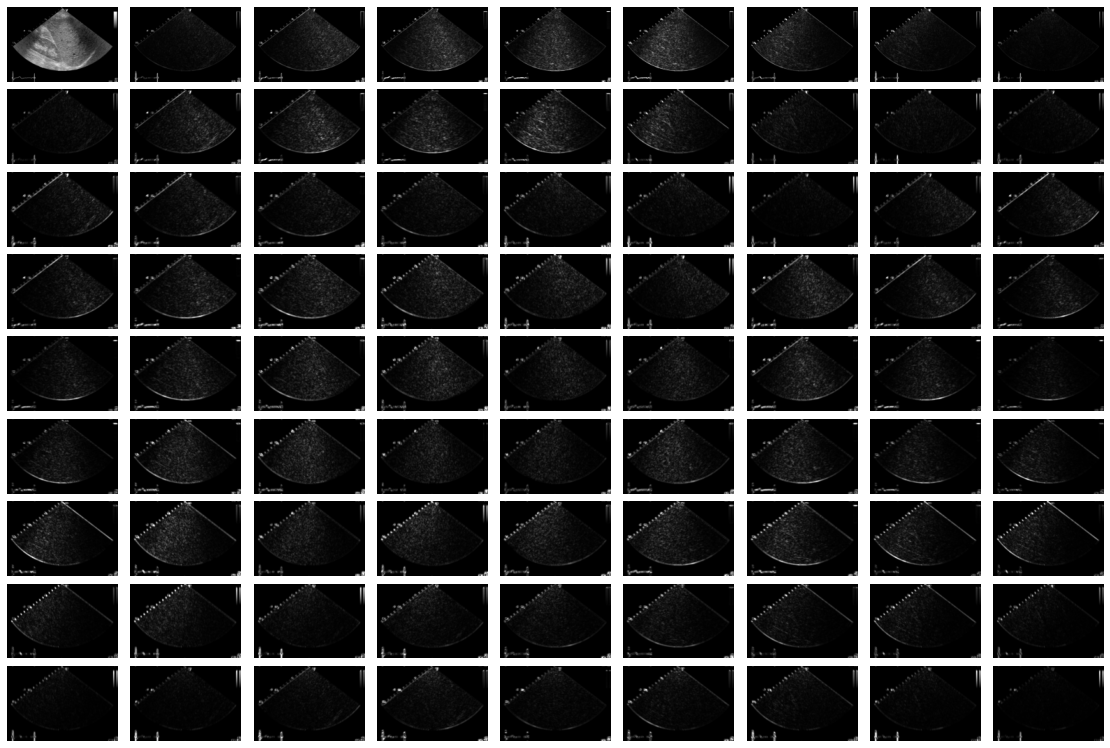

In [6]:
# show images
sf = scattering_features[0].view(scattering_features.shape[1],scattering_features.shape[2], scattering_features.shape[3]).cpu()
npimg = np.uint8(sf)

f, axarr = plt.subplots(9,9, figsize=(scattering_features.shape[3]/8, scattering_features.shape[2]/8))
count = 0
for i in range(0, 9) :
    for j in range(0, 9) :
        axarr[i,j].imshow(sf[count], cmap='gray')
        axarr[i,j].axis('off')
        count = count +1
        axarr[i,j].set_xticklabels([])
        axarr[i,j].set_yticklabels([])
        axarr[i,j].set_aspect('equal')

f.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

# Visualize Scattering Disk Display
Reference : https://www.kymat.io/gallery_2d/plot_scattering_disk.html#sphx-glr-gallery-2d-plot-scattering-disk-py
The code to create this visualization was taken from the reference above

In [7]:
# the image was randomly selected
dataset = create_dataframe_preproccessing()
dataset.head()

,id,labels,fat,fname
0,1,0,3,../data/02_interim/raw_images/1/P1_image1.jpg
1,1,0,3,../data/02_interim/raw_images/1/P1_image2.jpg
2,1,0,3,../data/02_interim/raw_images/1/P1_image3.jpg
3,1,0,3,../data/02_interim/raw_images/1/P1_image4.jpg
4,1,0,3,../data/02_interim/raw_images/1/P1_image5.jpg


In [21]:
def visualize_scattering_disk(src_img,scattering_coefficients, one_disk = False):# we skip the low pass filter
    norm = mpl.colors.Normalize(scattering_coefficients.min(), scattering_coefficients.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap="gray")
    nb_coeffs, window_rows, window_columns = scattering_coefficients.shape
    # Figure reproduction
    if one_disk:
        fig,ax = plt.subplots(figsize=(3,3))
    else: 
        fig,ax = plt.subplots(figsize=(10,10))
    #zeros_array = np.zeros((src_img.shape[0],src_img.shape[1]), dtype='float')
    plt.imshow(src_img,cmap='gray',interpolation='nearest', aspect='auto')
    ax.axis('off')
    L=8
    offset = 0.1
    if one_disk:
        ax=fig.add_subplot(1,1,1, projection='polar')
    for row in range(window_rows):
        for column in range(window_columns):
            if one_disk is False:
                ax=fig.add_subplot(window_rows, window_columns, 1 + column + row * window_rows, projection='polar')
            ax.set_ylim(0, 1)
            ax.axis('off')
            ax.set_yticklabels([])  # turn off radial tick labels (yticks)
            ax.set_xticklabels([])  # turn off degrees
            # ax.set_theta_zero_location('N')  # 0° to North
            coefficients = scattering_coefficients[:, row, column]
            for j in range(J):
                for l in range(L):
                    coeff = coefficients[l + (J - 1 - j) * L]
                    color = mpl.colors.to_hex(mapper.to_rgba(coeff))
                    ax.bar(x=(4.5+l) *  np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)
                    ax.bar(x=(4.5+l+L) * np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)
    plt.show()

In [22]:
def compute_scattering(src_img, L=8, J=3):
    L = L
    J = J
    scattering = Scattering2Dnumpy(J=J, shape=src_img.shape, L=L, max_order=2,frontend='numpy')
    src_img_tensor = src_img.astype(np.float32) / 255.
    scattering_coefficients = scattering(src_img_tensor)
    print("coeffs shape: ", scattering_coefficients.shape)
    # Invert colors
    scattering_coefficients = -scattering_coefficients
    return scattering_coefficients

In [23]:
def crop_patches(im1):
    left = 180
    top =  M/ 4
    right = 400
    bottom = 3 * M / 4
    # Cropped image of above dimension 
    # (It will not change orginal image) 
    im = im1.crop((left, top, right, bottom)) 
    return im 

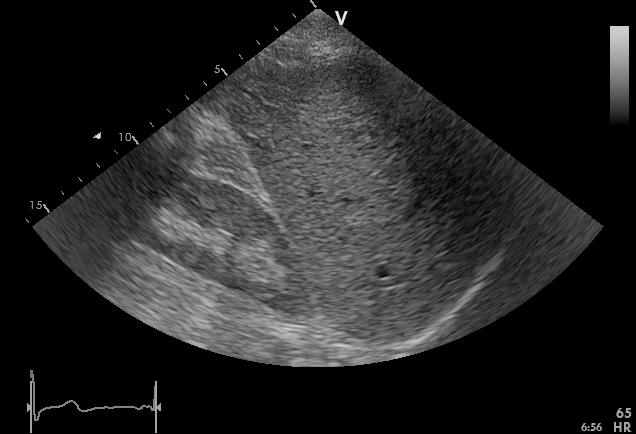

In [24]:
# visualize scattering disk when fat is low
img_name = os.path.join(os.getcwd(),dataset['fname'].iloc[0])
im1= Image.open(img_name)
im1

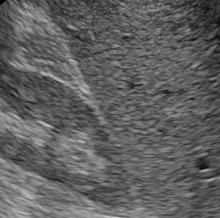

In [25]:
crop_patches(im1)

In [34]:
src_img = Image.open(img_name).convert('L').resize((32,32))
src_img = np.array(src_img)
print("img shape: ", src_img.shape)
scattering_coefficients = compute_scattering(src_img, L=8, J=3)


img shape:  (32, 32)
coeffs shape:  (217, 4, 4)


### A. Visualize First Order Coefficients - Fat = 3%

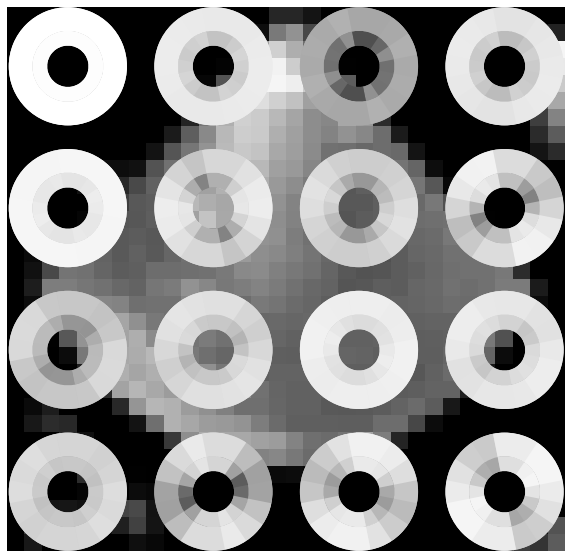

In [35]:
visualize_scattering_disk(src_img,scattering_coefficients[1:25, :, :])

### B. Visualize First Second Coefficients - Fat = 3%

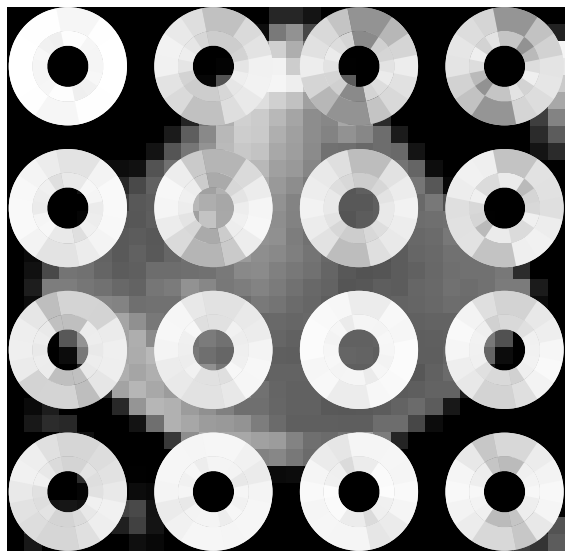

In [36]:
visualize_scattering_disk(src_img,scattering_coefficients[26:, :, :])

### C. Visualize First Order Coefficients - Fat = 70%

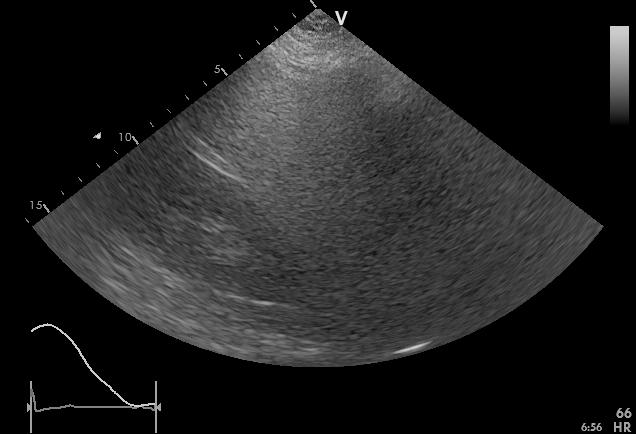

In [29]:
# visualize scattering disk when fat is low
img_name = os.path.join(os.getcwd(),dataset['fname'].iloc[340])
im1= Image.open(img_name)
im1

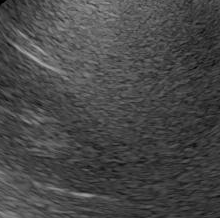

In [30]:
crop_patches(im1)

In [31]:
src_img = Image.open(img_name).convert('L').resize((32,32))
src_img = np.array(src_img)
print("img shape: ", src_img.shape)
scattering_coefficients =compute_scattering(src_img, L=8, J=3)

img shape:  (32, 32)
coeffs shape:  (217, 4, 4)


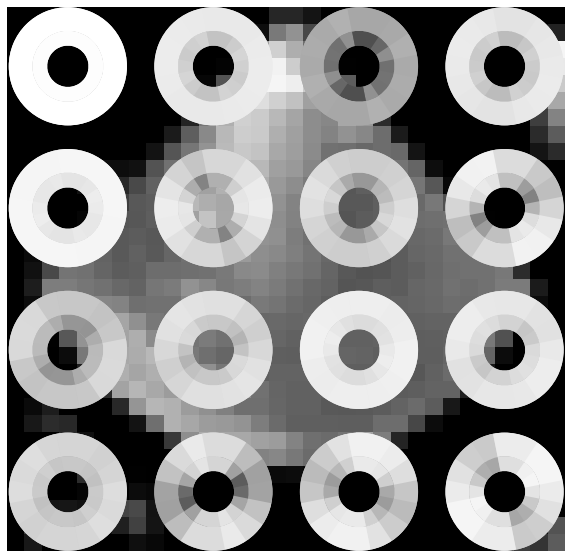

In [32]:
visualize_scattering_disk(src_img,scattering_coefficients[1:25, :, :])

### D. Visualize First Second Coefficients - Fat = 70%

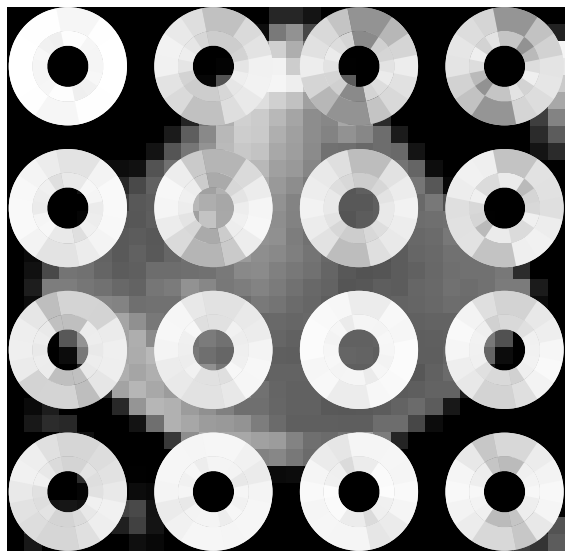

In [33]:
visualize_scattering_disk(src_img,scattering_coefficients[26:, :, :])

The image below is a summary of the visualization.

# Save scattering features

In [7]:
sc_features = scattering_features.view(scattering_features.shape[0], scattering_features.shape[1] * scattering_features.shape[2] * scattering_features.shape[3])
X = sc_features.cpu().numpy()
df_sc = pd.DataFrame(X)
df_scattering = pd.concat([df['id'], df['class'], df_sc], axis=1)
df_scattering.shape

(550, 1390934)

In [8]:
# Create a dict for the scattering features, and parameters - for model not using tensors
scatter_dict = {'df':df_scattering,
                'J':J,
                'M':M,
                'N':N}

with open('../data/03_features/scattering_features.pickle', 'wb') as handle:
    pickle.dump(scatter_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
# Create a dict for the scattering features, and parameters
scatter_dict_tensor = {
                'features':scattering_features,
                'label' : df['class'],
                'pid' : df['id'],
                'J':J,
                'M':M,
                'N':N}

with open('../data/03_features/scatter_dict_tensor.pickle', 'wb') as handle:
    pickle.dump(scatter_dict_tensor, handle, protocol=pickle.HIGHEST_PROTOCOL)